In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from functools import partial
from tensorflow.keras.applications.vgg16 import VGG16
import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

2023-04-13 13:43:49.163539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# dataset_path = '/Users/George_1/PycharmProjects/MLFINAL2/funny.csv'
# data = pd.read_csv(dataset_path)
#
#
# def download_image(url):
#     try:
#         response = requests.get(url, timeout=5)
#         img = Image.open(io.BytesIO(response.content))
#         return img
#     except:
#         return None
#
#
# images = []
# scores = []
#
# for index, row in data.iterrows():
#     url = row['url']
#     score = row['score']
#     img = download_image(url)
#
#     if img is not None:
#         images.append(img)
#         scores.append(score)
#
# input_size = (128, 128)
# X = np.array([np.array(img.convert('RGB').resize(input_size[:2])) for img in images])
# y = np.array(['1' if score > 100 else '0' for score in scores])
#
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4,stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
#
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_val = encoder.transform(y_val)
# y_test = encoder.transform(y_test)


#______________________________________________________________________
from sklearn.model_selection import StratifiedShuffleSplit

dataset_path = '/Users/George_1/PycharmProjects/ML3/funny.csv'
data = pd.read_csv(dataset_path)

def download_image(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(io.BytesIO(response.content))
        return img
    except:
        return None

images = []
scores = []

for index, row in data.iterrows():
    url = row['url']
    score = row['score']
    img = download_image(url)

    if img is not None:
        images.append(img)
        scores.append(score)

input_size = (128, 128)
X = np.array([np.array(img.convert('RGB').resize(input_size[:2])) for img in images])
y = np.array([1 if score > 100 else 0 for score in scores])


# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_val = encoder.transform(y_val)
# y_test = encoder.transform(y_test)









In [3]:
np.save("/Users/George_1/PycharmProjects/ML3/X.npy",X)
np.save("/Users/George_1/PycharmProjects/ML3/y.npy",y)

In [ ]:
X= np.load("/Users/George_1/PycharmProjects/ML3/X.npy")
y=np.load("/Users/George_1/PycharmProjects/ML3/y.npy")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_index, temp_index = next(sss.split(X, y))
X_train, X_temp = X[train_index], X[temp_index]
y_train, y_temp = y[train_index], y[temp_index]

sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(sss_val_test.split(X_temp, y_temp))
X_val, X_test = X_temp[val_index], X_temp[test_index]
y_val, y_test = y_temp[val_index], y_temp[test_index]

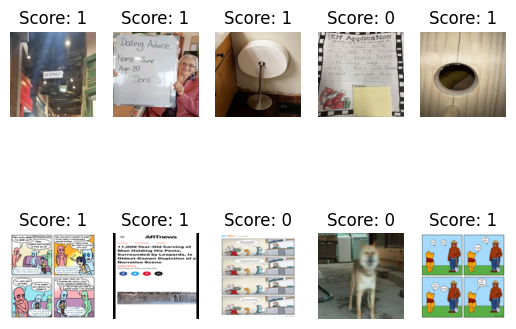

In [4]:
# Select some random indices to plot
indices = np.random.choice(len(X_train), size=10, replace=False)

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5)
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[indices[i]])
    ax.set_title('Score: {}'.format(y_train[indices[i]]))
    ax.axis('off')

plt.show()


In [9]:
input_size = (128, 128, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

for layer in base_model.layers[:-16]:  # Freeze all layers except the last 16
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer="TruncatedNormal")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu',kernel_initializer = "TruncatedNormal")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# model_dir = '/Users/George_1/PycharmProjects/ML3/'
# latest_model = max(glob.glob(model_dir + 'best_model_100*.h5'), key=os.path.getctime)
# filename_parts = os.path.splitext(os.path.basename(latest_model))[0].split('_')
# latest_num = next((int(s) for s in filename_parts if s.isdigit()), None)
#
# if latest_num is None:
#     print("Unable to find a valid integer value in the latest model filename. Please check the filename format.")
#     sys.exit(1)
#
# next_num = latest_num + 1
# new_model_filename = 'best_model_100_{}.h5'.format(next_num)
# new_model_filepath = os.path.join(model_dir, new_model_filename)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



model.save("Test1.h5")
batch_size = 32
epochs = 10

steps_per_epoch = len(X_train) // batch_size
print("Starting training...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1 )



Starting training...
Epoch 1/10


2023-04-13 14:08:08.284646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-13 14:08:10.141668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 8.3424 - accuracy: 0.5110

2023-04-13 14:08:29.205325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 23s 2s/step - loss: 8.3424 - accuracy: 0.5110 - val_loss: 0.9591 - val_accuracy: 0.5641
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 1.1563 - accuracy: 0.5688 - val_loss: 0.6478 - val_accuracy: 0.6923
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.6872 - accuracy: 0.6458 - val_loss: 0.6616 - val_accuracy: 0.6667
Epoch 4/10
10/10 [==============================] - 15s 1s/step - loss: 0.6778 - accuracy: 0.6113 - val_loss: 0.6517 - val_accuracy: 0.6667
Epoch 5/10
10/10 [==============================] - 15s 1s/step - loss: 0.6676 - accuracy: 0.6176 - val_loss: 0.6535 - val_accuracy: 0.6667
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.6809 - accuracy: 0.6301 - val_loss: 0.6788 - val_accuracy: 0.6667
Epoch 7/10
10/10 [==============================] - 14s 1s/step - loss: 0.6777 - accuracy: 0.6520 - val_loss: 0.6565 - val_accuracy: 0.6667
Epoch 8/10
10/10 [=============

2023-04-13 14:11:21.630442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 852ms/step


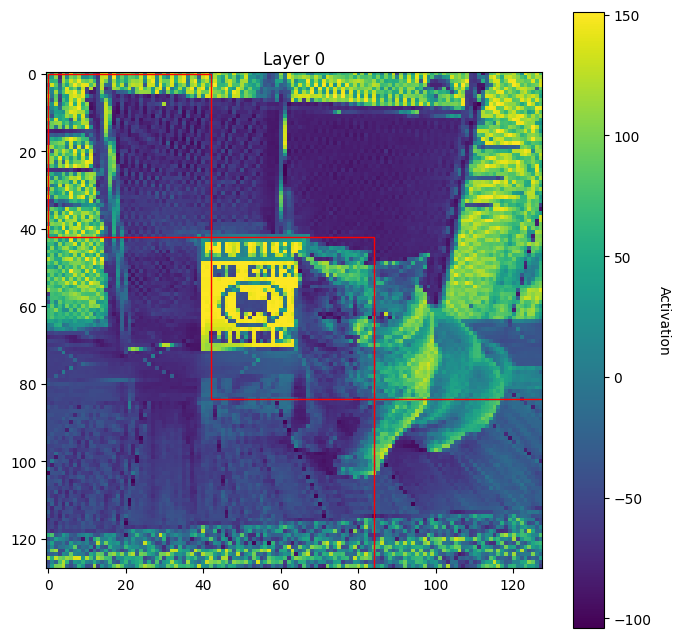

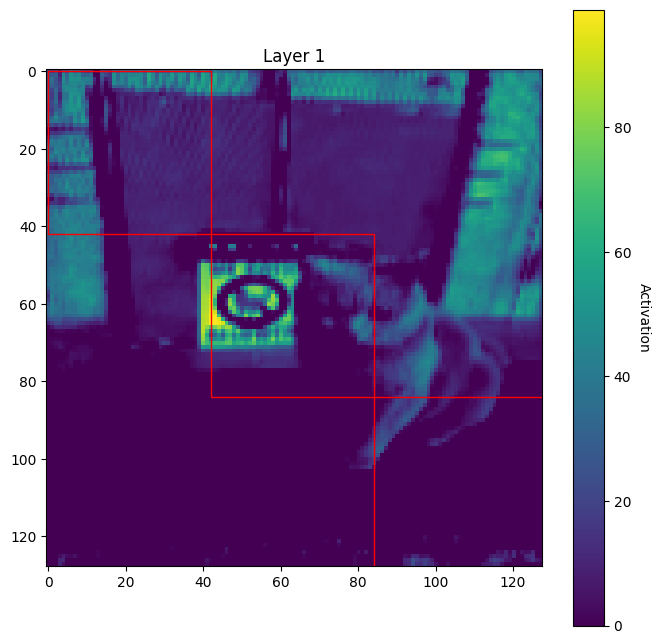

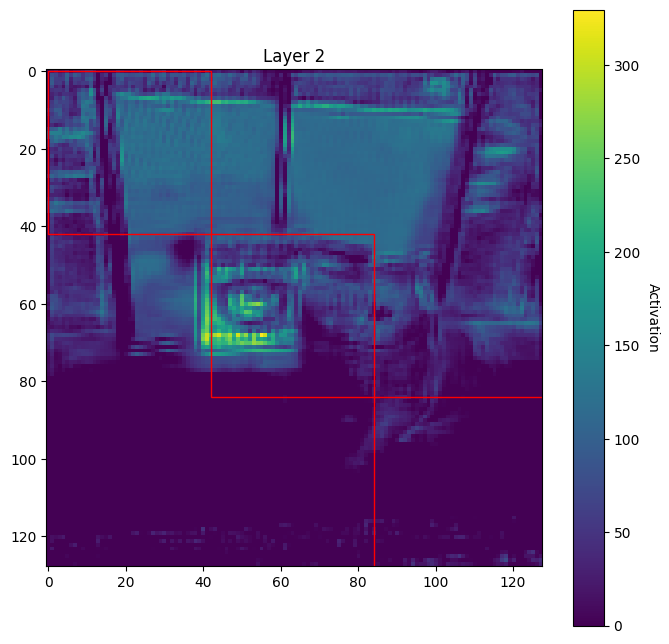

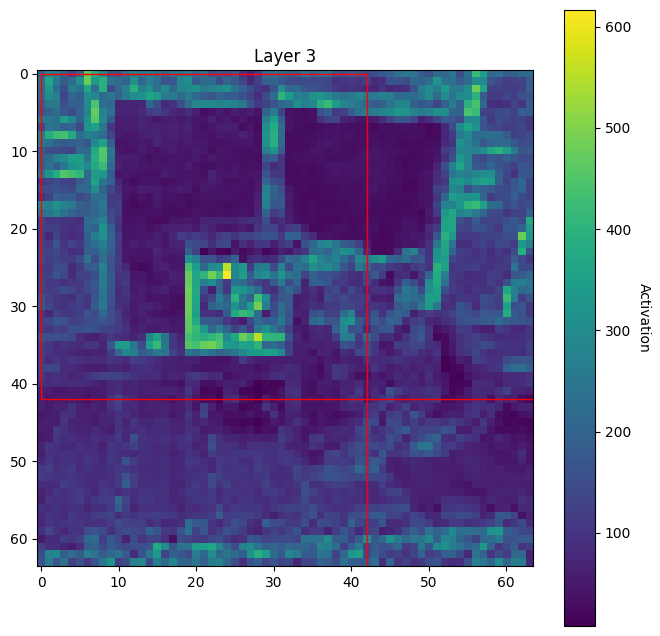

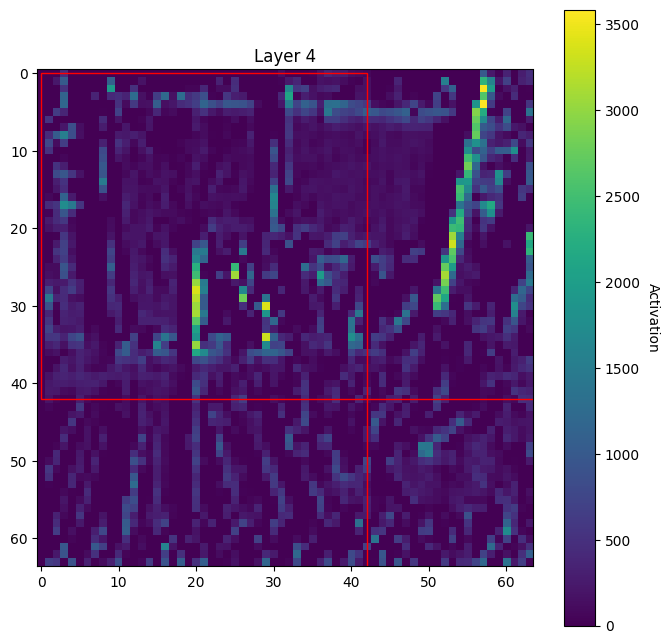

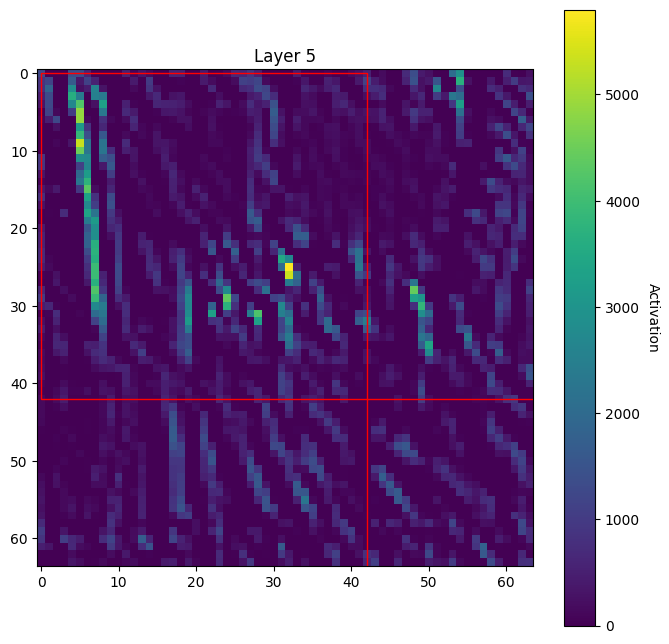

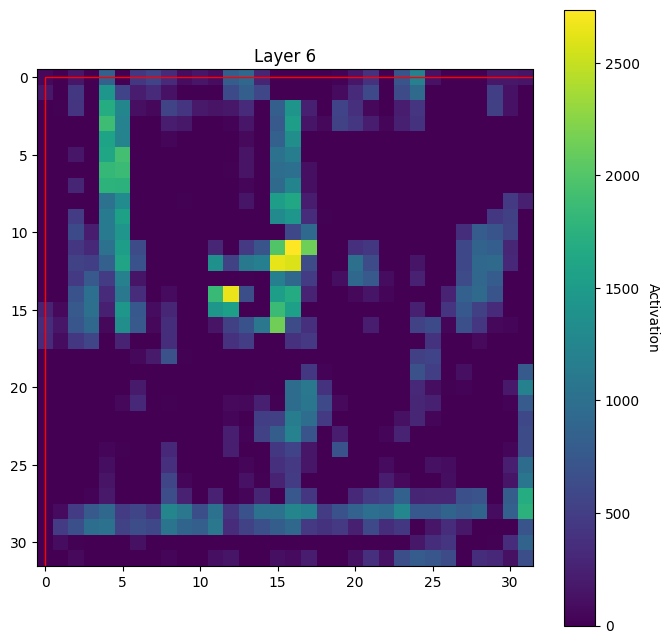

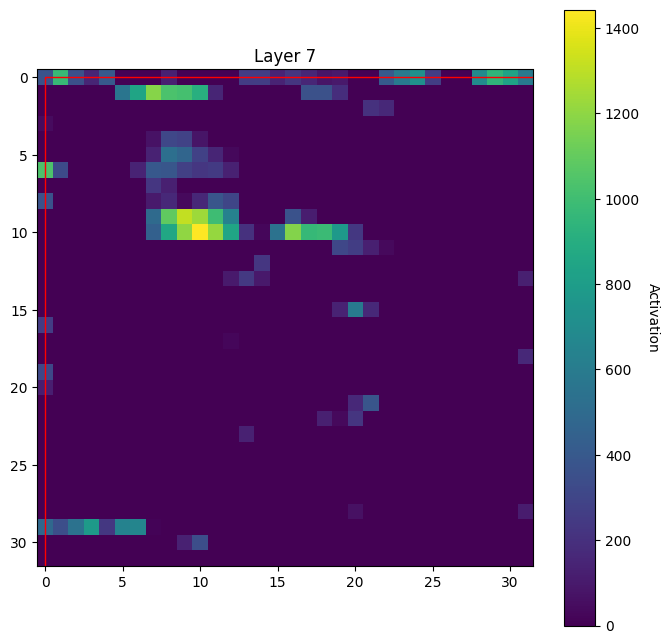

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


# Load an example image
img_path = '/Users/George_1/PycharmProjects/ML3/90k1incvmdta1.jpeg'
img = image.load_img(img_path, target_size=(128, 128))

# Convert the image to a numpy array and preprocess it
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract the outputs of intermediate layers in the model
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)

# Define the regions of interest
rois = [(0, 0, 42, 42), (42, 42, 84, 84), (84, 84, 128, 128)]

# Plot the activations for each layer
for i, activation in enumerate(activations):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(activation[0, :, :, i], cmap='viridis')
    plt.title('Layer ' + str(i))
    # Highlight the regions of interest
    for roi in rois:
        rect = plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0], roi[3] - roi[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # Add a color bar legend
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")
    plt.show()


In [12]:
from sklearn.metrics import roc_curve, auc

score = model.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr1, tpr1)
print('Test ROC AUC:', roc_auc)

4/4 [==============================] - 2s 500ms/step - loss: 0.6581 - accuracy: 0.6581

Validation loss / accuracy: 0.6581 / 0.6581


2023-04-13 14:11:43.794227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 495ms/step
Validation ROC AUC: 0.5815253122945431
4/4 [==============================] - 1s 355ms/step - loss: 0.6588 - accuracy: 0.6667

Test loss / accuracy: 0.6588 / 0.6667
4/4 [==============================] - 1s 335ms/step
Test ROC AUC: 0.5192307692307692


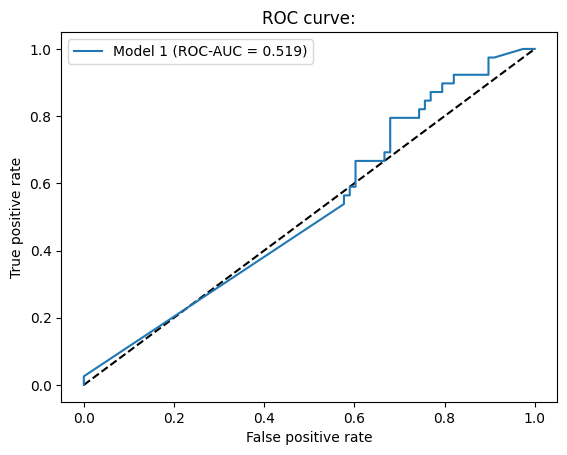

In [13]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr1, tpr1, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve:')
plt.legend(loc='best')
plt.show()